<a href="https://colab.research.google.com/github/ejjeong11/Business-Analytics-Toolbox/blob/master/Factor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Proposal**

Predict which members are likely to be hesitant 
Recommend solutions to increase vaccination rate for these members
Design targeted outreaches for these members (grouping)
Prioritize to reach the most vulnerable and underserved populations to receive health solutions.  

**Business Problem**

According to analysis, preventable COVID-19 hospitalizations among unvaccinated adults cost over $5 Billion. Since Humana is covering costs for COVID-19 treatment, it means they can save these costs. Also, Covid vaccination prevents ICU admissions, lowering severe symptoms, especially among vulnerable populations.
Our goal is to figure out the vaccine-hesitant group, suggest recommendations to increase vaccination, and estimate how much Humana can earn or save.

**Project Proposal**
*   Predict vaccine hesitancy
*   Find features of vaccination-hesitant people (XgBoost Feature Importance, RandomForestClassifier, LightGBM, Shapley Additive  Explanations SHAP)
*   Find vulnerable populations, susceptible to Covid and ICU admission (by research)
*   Estimate Covid infection rate, Hospitalization, ICU cost (by research)
*   Suggest Recommendations for each group

*referenced finalist work

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt

import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Humana/Cleaned_data.csv")
df

In [4]:
dfs = df.sample(10000, random_state=1111)

In [5]:
X_df = dfs.drop('covid_vaccination', axis=1)
X_df.shape

(10000, 588)

In [6]:
y_df = dfs['covid_vaccination']
y_df.shape

(10000,)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=833)

## Target Variable

In [9]:
y_train.mean()

0.16957142857142857

## Feature Importance

In [ ]:
#ramdonforest classifier
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
# df = pd.get_dummies(df)
# Drop redundant columns (for features with two unique values)
# drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No',
#         'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No']
#x, y = dfs.loc[:, dfs.columns != 'covid_vaccination'], dfs.loc[:, 'covid_vaccination']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(Xtrain, ytrain)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)
plt.figure(figsize=(20,50))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

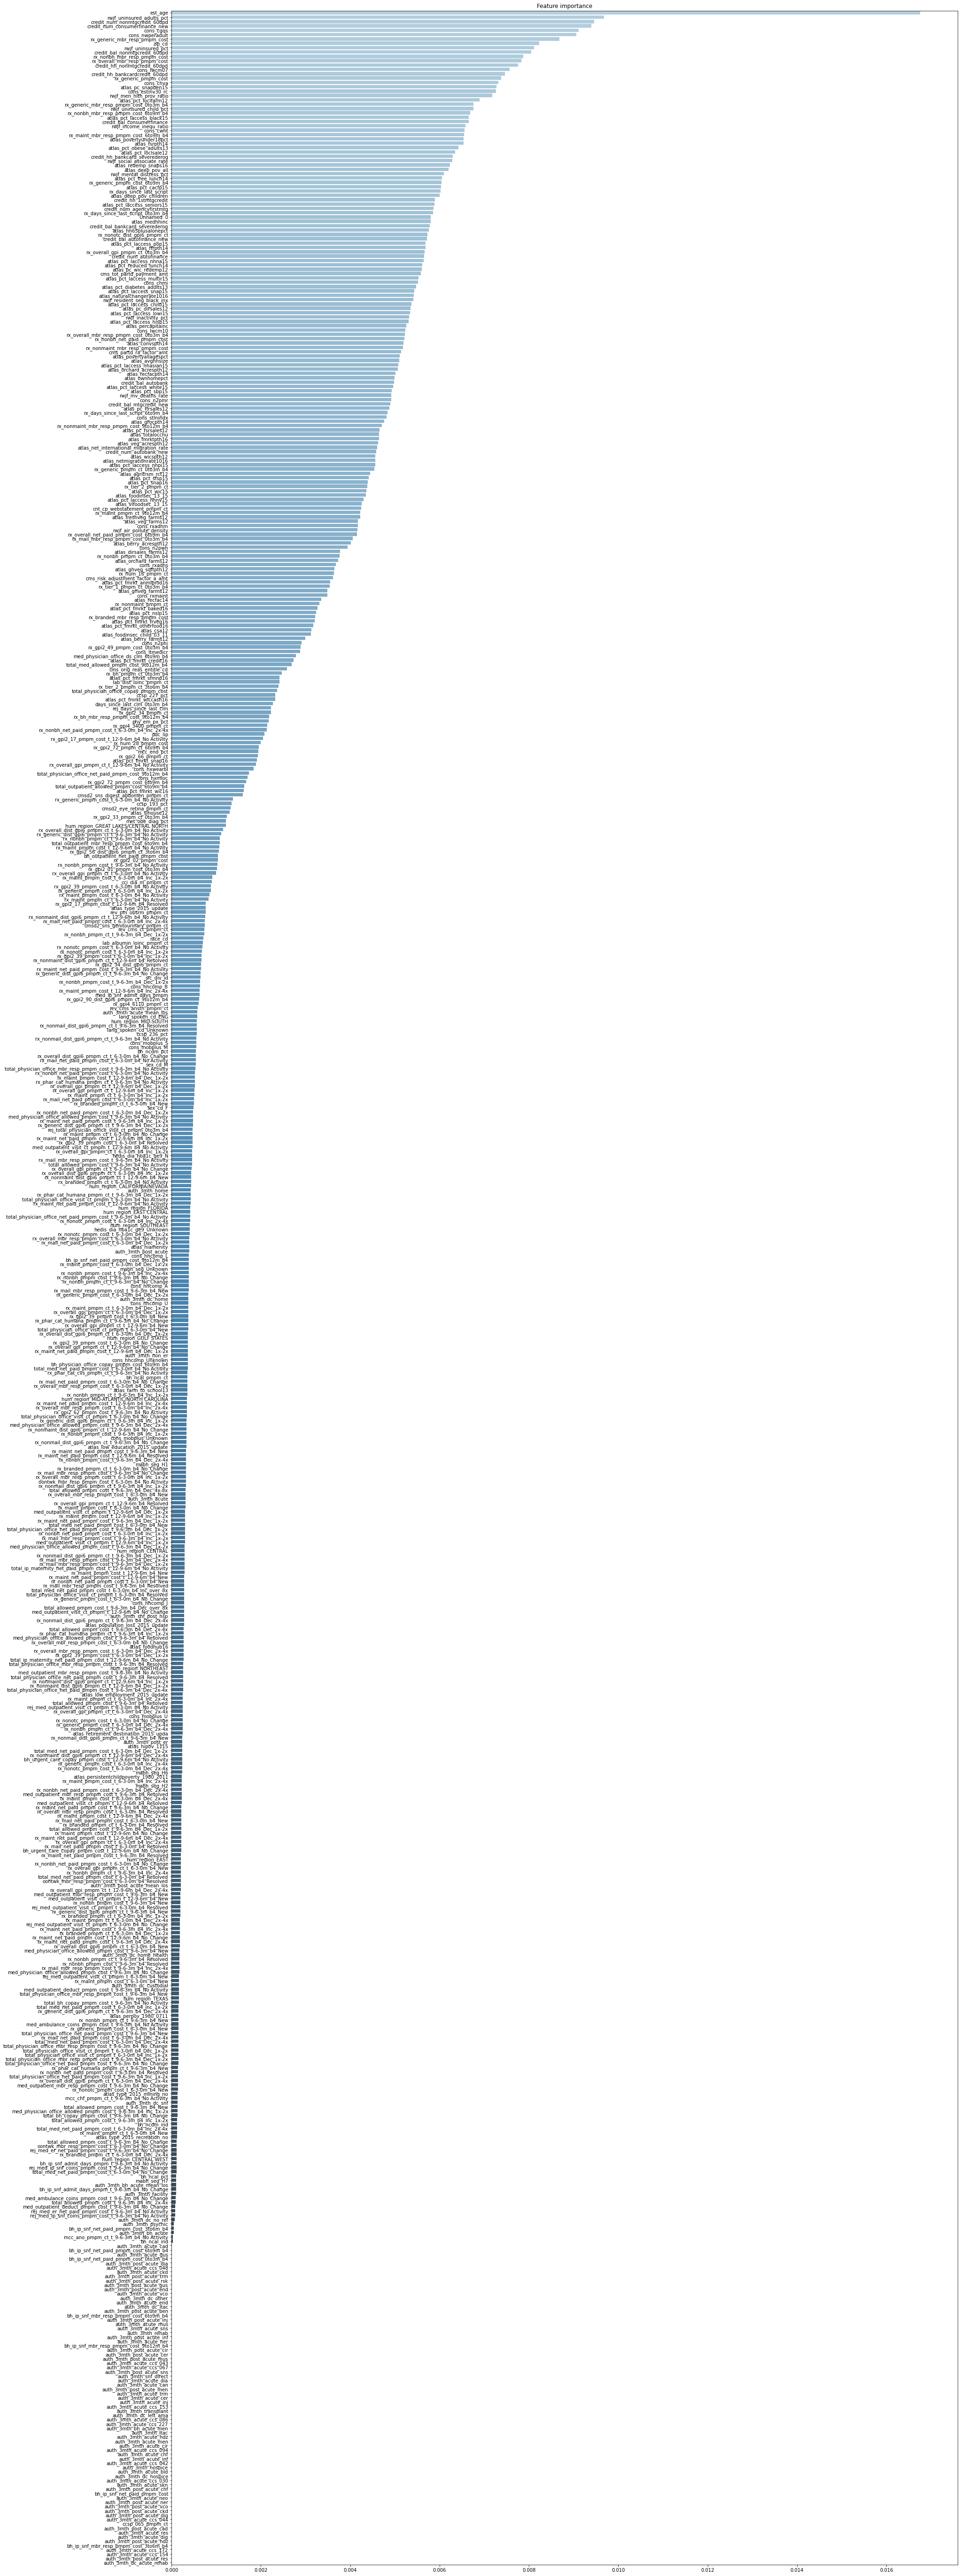

In [ ]:
imp = pd.Series(data=clf.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)
plt.figure(figsize=(30,100))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

In [ ]:
#Top 5
sel = SelectFromModel(estimator = clf, prefit = True , max_features=5)
sel.get_support()
selected_feat= Xtrain.columns[(sel.get_support())]
selected_feat

Index(['est_age', 'rwjf_uninsured_adults_pct', 'credit_num_nonmtgcredit_60dpd',
       'cons_cgqs', 'credit_num_consumerfinance_new'],
      dtype='object')

In [ ]:
#Top 10
sel = SelectFromModel(estimator = clf, prefit = True , max_features=10)
sel.get_support()
selected_feat= Xtrain.columns[(sel.get_support())]
selected_feat

Index(['credit_bal_nonmtgcredit_60dpd', 'rwjf_uninsured_pct', 'est_age',
       'rwjf_uninsured_adults_pct', 'cons_nwperadult',
       'rx_generic_mbr_resp_pmpm_cost', 'credit_num_nonmtgcredit_60dpd',
       'cons_cgqs', 'zip_cd', 'credit_num_consumerfinance_new'],
      dtype='object')

# Top 10 features

'est_age'

rwjf_uninsured_adults_pct : Clinical Care - Percentage of adults under age 65 without health insurance

'credit_num_nonmtgcredit_60dpd' : Number Non-Mortgage Loan Accts 60+ Days Past Due

'credit_num_consumerfinance_new' : Number Consumer Finance Accts New w/in 12 months

'cons_cgqs' Census Geo-unit Quality Score

'cons_nwperadult' Net Worth Per Adult

'rx_generic_mbr_resp_pmpm_cost' member reponsible cost per month of prescriptions related to generic drugs in the past one year

'zip_cd' Member zip code

'rwjf_uninsured_pct' Clinical Care - Percentage of adults under age 65 without health insurance

'credit_bal_nonmtgcredit_60dpd' Balance Non-Mortgage Loan Accts 60+ Days Past Due

#Average value by Covid vaccination

In [ ]:
#0=not vaccinated, 1=vaccinated
dfs.pivot_table(values=selected_feat, columns="covid_vaccination", aggfunc="mean")

covid_vaccination,0,1
cons_cgqs,84.377918,87.251878
cons_nwperadult,149209.240451,186372.332948
credit_bal_nonmtgcredit_60dpd,2647.275393,2495.943671
credit_num_consumerfinance_new,0.213381,0.196764
credit_num_nonmtgcredit_60dpd,0.617322,0.570096
est_age,70.745918,73.806470
rwjf_uninsured_adults_pct,0.139116,0.128058
rwjf_uninsured_pct,0.112071,0.105054
rx_generic_mbr_resp_pmpm_cost,10.967673,14.609308
zip_cd,48496.813520,49573.463316


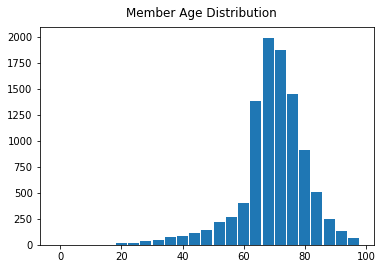

In [ ]:
#age distribution
plt.hist(dfs['est_age'],bins=25,alpha=1,rwidth=0.9,align='left',density=0,range=(0,100));
plt.suptitle('Member Age Distribution',y=0.95);

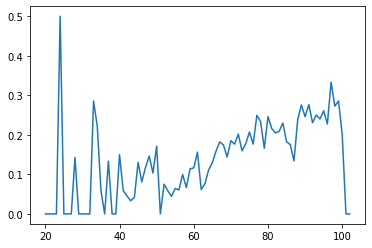

In [ ]:
#vaccination rate by age
age_data=dfs.groupby('est_age')['covid_vaccination'].agg('mean')
plt.plot(age_data);

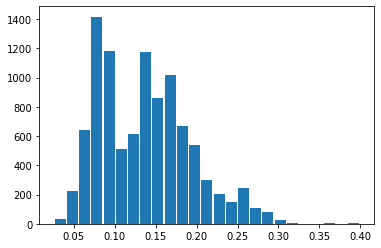

In [ ]:
plt.hist(dfs['rwjf_uninsured_adults_pct'],bins=25,alpha=1,rwidth=0.9);

# non vaccinated group
1.average age is lower

2.average bank balance is lower

3.black (white)

4.participate in food subsidy program

5.lower median income

6.without healthinsurance (?)

# vaccinated group -shoud check

7.mental distress (?)

8.generic problem

9.member reponsible cost per month of prescriptions related to non behavioral health drugs in the past sixth to ninth month prior to the score date

10.member reponsible cost per month of prescriptions related to non behavioral health drugs in the past one year

# Xgboost

In [ ]:
pip install xgboost

In [27]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [34]:
xgbdict = xgb.get_booster().get_fscore()

# TOP 10 Features by Xgboost
* Age
* Total Part D Payment Amount
* Census Median Household Income
* Household food insecurity (%, three-year average), 2013-15
* Multiracial, low access to store
* Clinical Care - Percentage of children under age 19 without health insurance
* SNAP households, low access to store
* Total number of occupied housing units
* Estimated Household Investable Assets Recoded
* Expenditures per capita, fast food





In [37]:
sorted(xgbdict.items(), key=lambda x: x[1], reverse=True)

[('est_age', 25),
 ('cms_tot_partd_payment_amt', 17),
 ('cons_chmi', 13),
 ('atlas_foodinsec_13_15', 12),
 ('atlas_pct_laccess_multir15', 12),
 ('rwjf_uninsured_child_pct', 11),
 ('atlas_pct_laccess_snap15', 10),
 ('atlas_totalocchu', 9),
 ('cons_estinv30_rc', 8),
 ('atlas_pc_ffrsales12', 8),
 ('atlas_pct_fmrkt_wiccash16', 8),
 ('rwjf_inactivity_pct', 8),
 ('atlas_grocpth14', 8),
 ('atlas_deep_pov_all', 8),
 ('rwjf_uninsured_adults_pct', 7),
 ('rx_nonbh_pmpm_ct_0to3m_b4', 7),
 ('rx_generic_pmpm_cost_6to9m_b4', 7),
 ('rwjf_income_inequ_ratio', 7),
 ('atlas_freshveg_farms12', 7),
 ('atlas_pct_laccess_white15', 7),
 ('atlas_fmrktpth16', 7),
 ('credit_bal_consumerfinance', 7),
 ('credit_bal_bankcard_severederog', 7),
 ('cms_partd_ra_factor_amt', 7),
 ('atlas_pct_loclfarm12', 7),
 ('atlas_ownhomepct', 7),
 ('rx_generic_pmpm_ct_0to3m_b4', 6),
 ('rx_days_since_last_script_6to9m_b4', 6),
 ('atlas_pct_cacfp15', 6),
 ('cons_lwcm10', 6),
 ('cons_hxwearbl', 6),
 ('cnt_cp_webstatement_pmpm_ct', 6),

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


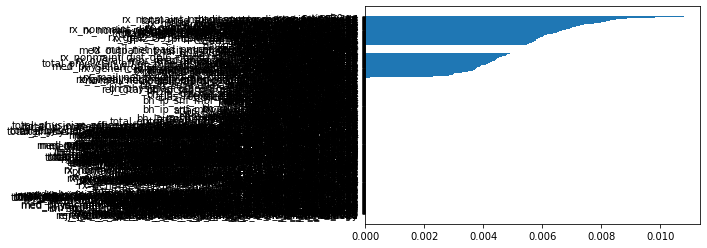

In [ ]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(names[sorted_idx], xgb.feature_importances_[sorted_idx])


# SHAP interaction Xgboost

In [52]:
pip install shap

     |████████████████████████████████| 356 kB 12.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491645 sha256=752d777c4085bd7adbbdabae6fb7c28b680764d1c597303d769972ad3dcdf2e7
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [55]:
import shap

In [57]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

In [60]:
shap.initjs()

In [61]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

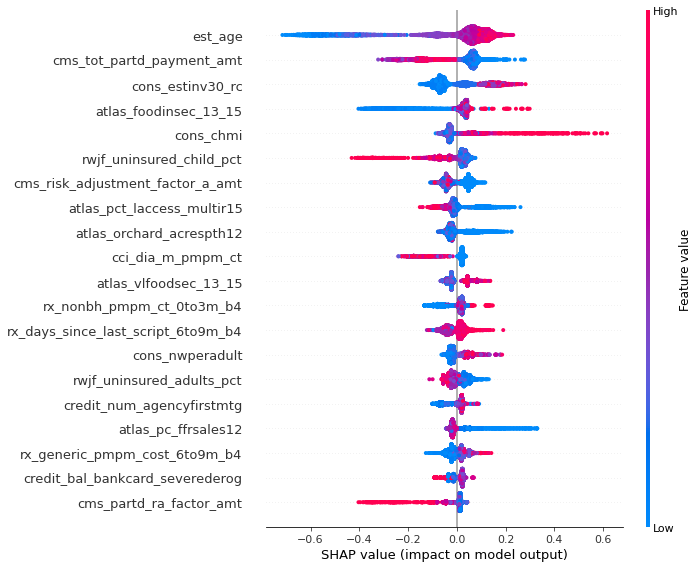

In [64]:
shap.summary_plot(shap_values, X_train)

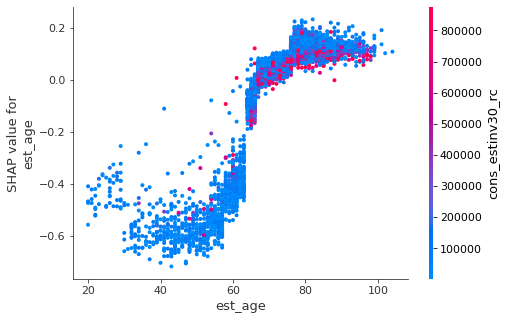

In [67]:
shap.dependence_plot('est_age', shap_values, X_train, display_features=X_train)

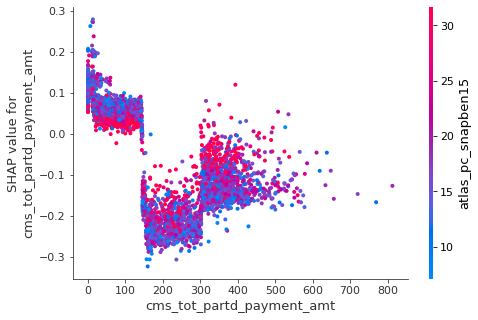

In [69]:
shap.dependence_plot('cms_tot_partd_payment_amt', shap_values, X_train, display_features=X_train)

# Light GBM

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(Xtrain)
x_test = sc.transform(Xtest)

In [ ]:
import lightgbm as lgb
d_train = lgb.Dataset(x_train, label=ytrain)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [ ]:
#Prediction
y_pred=clf.predict(x_test)
#convert into binary values
for i in range(0,99):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,ytest)

# Factor Analysis

In [46]:
pip install factor_analyzer

     |████████████████████████████████| 40 kB 4.6 MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-py3-none-any.whl size=40395 sha256=0cd1f34b3d9c3d3d9f985445dc29be4c1896d16c98da0f9dc2f12c75661d5772
  Stored in directory: /root/.cache/pip/wheels/8d/9e/4c/fd4cb92cecf157b13702cc0907e5c56ddc48e5388134dc9f1a
Successfully built factor-analyzer


In [47]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(dfs)
chi_square_value, p_value

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(nan, nan)

In [49]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(dfs)
kmo_model

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:205: RuntimeWarning: invalid value encountered in sqrt
  Is = np.sqrt(1 / np.diag(m))


nan

In [51]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.analyze(dfs, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

AttributeError: ignored

In [ ]:
#TOP25, whole dataset
df.pivot_table(values=selected_feat, columns="covid_vaccination", aggfunc="mean")

covid_vaccination,0,1
atlas_ffrpth14,0.645997,0.652202
atlas_fsrpth14,0.700174,0.718184
atlas_medhhinc,52342.499283,53713.626298
atlas_naturalchangerate1016,1.774018,1.821704
atlas_pc_snapben15,18.050347,17.342155
atlas_pct_cacfp15,1.297591,1.294978
atlas_pct_laccess_black15,1.731484,1.642993
atlas_pct_laccess_white15,14.881744,15.130827
atlas_pct_sbp15,4.591303,4.435927
atlas_pct_wic15,2.399010,2.358226


In [ ]:
a=list(selected_feat)
dfs[a].describe()

,credit_bal_nonmtgcredit_60dpd,rwjf_uninsured_pct,est_age,rwjf_uninsured_adults_pct,cons_nwperadult,rx_generic_mbr_resp_pmpm_cost,credit_num_nonmtgcredit_60dpd,cons_cgqs,zip_cd,credit_num_consumerfinance_new
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2621.079872,0.110856,71.275700,0.137202,155642.171762,11.598040,0.609147,84.875400,48683.181600,0.210505
std,1098.563089,0.042898,10.837557,0.056197,193047.130066,17.690257,0.261457,14.165195,22776.008409,0.109922
min,78.880000,0.021305,20.000000,0.026159,-2500.000000,0.000000,0.024963,60.000000,602.000000,0.020703
25%,1878.691671,0.075303,67.000000,0.087886,22343.750000,0.460000,0.425772,76.000000,31063.750000,0.134968
50%,2435.571343,0.109594,72.000000,0.133566,100000.000000,4.713333,0.569585,83.000000,46039.500000,0.177876
75%,3153.070784,0.137157,78.000000,0.171921,200000.000000,15.771458,0.759974,89.000000,66559.000000,0.253308
max,14804.844607,0.324604,102.000000,0.399028,1000000.000000,196.615840,2.172594,170.000000,99827.000000,0.833366


In [ ]:
dfs[a].head()

,credit_bal_nonmtgcredit_60dpd,rwjf_uninsured_pct,est_age,rwjf_uninsured_adults_pct,cons_nwperadult,rx_generic_mbr_resp_pmpm_cost,credit_num_nonmtgcredit_60dpd,cons_cgqs,zip_cd,credit_num_consumerfinance_new
904469,3335.226550,0.120413,80,0.142579,5000.0,8.070833,0.786005,74.0,36854,0.428799
48026,2192.347932,0.105198,73,0.142999,100000.0,0.000000,0.630323,83.0,47023,0.134893
560289,3417.781350,0.105907,89,0.130619,-2500.0,2.265833,1.088478,88.0,35020,0.437897
147335,2270.431374,0.172101,71,0.202268,250000.0,63.780834,0.316793,106.0,33420,0.152474
814071,2139.504534,0.168334,36,0.181682,-2500.0,17.714166,0.625093,70.0,47039,0.285321


## Lasso Regression

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from numpy import arange

In [11]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
y_pred_lasso = lasso.predict(X_test)

In [13]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

MAE: -0.273
Config: {'alpha': 0.01}


In [23]:
n = list(X_train.columns)

In [41]:
lassofeature = dict(zip(lasso.coef_, n))

In [42]:
print(lassofeature)

{-1.927344054092099e-08: 'Unnamed: 0', 0.0: 'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change', 7.013787019939454e-05: 'rx_gpi2_72_pmpm_cost_6to9m_b4', -9.800857949189355e-06: 'credit_bal_nonmtgcredit_60dpd', 3.4201210966063248e-06: 'credit_bal_consumerfinance', 2.670055390807553e-07: 'atlas_percapitainc', -0.00011143642327476098: 'cms_tot_partd_payment_amt', 4.764148745914589e-08: 'atlas_redemp_snaps16', -2.025895188693157e-08: 'atlas_agritrsm_rct12', -0.00013155296325343142: 'rx_days_since_last_script', 5.922851543955097e-07: 'credit_bal_mtgcredit_new', 7.995964821967318e-08: 'cons_nwperadult', 1.7841333871690018e-08: 'atlas_totalocchu', -1.803296767784556e-06: 'rx_nonbh_net_paid_pmpm_cost', -3.670730600084526e-06: 'total_med_allowed_pmpm_cost_9to12m_b4', -5.512259968059932e-06: 'credit_bal_bankcard_severederog', 8.702763520957209e-08: 'cons_estinv30_rc', -9.802890027745365e-06: 'credit_bal_autofinance_new', 1.4687280299065266e-06: 'atlas_ghveg_sqftpth12', -3.253755049769869e-08: '

In [43]:
dictionary_items = lassofeature.items()
sorted_items = sorted(dictionary_items)

In [44]:
sorted_items

[(-0.00013155296325343142, 'rx_days_since_last_script'),
 (-0.00011143642327476098, 'cms_tot_partd_payment_amt'),
 (-9.802890027745365e-06, 'credit_bal_autofinance_new'),
 (-9.800857949189355e-06, 'credit_bal_nonmtgcredit_60dpd'),
 (-5.512259968059932e-06, 'credit_bal_bankcard_severederog'),
 (-3.670730600084526e-06, 'total_med_allowed_pmpm_cost_9to12m_b4'),
 (-1.803296767784556e-06, 'rx_nonbh_net_paid_pmpm_cost'),
 (-3.7124322571810837e-07, 'zip_cd'),
 (-3.253755049769869e-08, 'atlas_medhhinc'),
 (-2.025895188693157e-08, 'atlas_agritrsm_rct12'),
 (-1.927344054092099e-08, 'Unnamed: 0'),
 (0.0, 'rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change'),
 (1.7841333871690018e-08, 'atlas_totalocchu'),
 (4.764148745914589e-08, 'atlas_redemp_snaps16'),
 (7.995964821967318e-08, 'cons_nwperadult'),
 (8.702763520957209e-08, 'cons_estinv30_rc'),
 (2.670055390807553e-07, 'atlas_percapitainc'),
 (5.922851543955097e-07, 'credit_bal_mtgcredit_new'),
 (1.4687280299065266e-06, 'atlas_ghveg_sqftpth12'),
 (

In [ ]:
#dfs = pd.get_dummies(data=dfs, columns=['sex', 'smoker', 'region'])  # 필요한 열들에 One-hot Encoding을 해준다
#X = insurance_df.drop(['charges'], axis=1)

polynomial_transformer = PolynomialFeatures(4)  # 4 차항 변형기를 정의
polynomial_features = polynomial_transformer.fit_transform(X.values)  #  4차 항 변수로 변환

features = polynomial_transformer.get_feature_names(X.columns)  # 새로운 변수 이름들 생성

X = pd.DataFrame(polynomial_features, columns=features)  # 다항 입력 변수를 dataframe으로 만들어 준다
y = insurance_df[['charges']]  # 목표 변수 정의

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

model = Lasso(alpha=1, max_iter=2000, normalize=True)
model.fit(X_train, y_train)

y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)

mse = mean_squared_error(y_train, y_train_predict)

print("training set에서 성능")
print("-----------------------")
print(f'오차: {sqrt(mse)}')

mse = mean_squared_error(y_test, y_test_predict)

print("testing set에서 성능")
print("-----------------------")
print(f'오차: {sqrt(mse)}')

In [ ]:
#age
df.groupby("covid_vaccination")["est_age"].mean()

covid_vaccination
0    70.605649
1    73.882900
Name: est_age, dtype: float64

In [ ]:
df.groupby("covid_vaccination")["est_age"].describe()
#how min, max age is same?

,count,mean,std,min,25%,50%,75%,max
covid_vaccination,,,,,,,,
0,805389.0,70.605649,11.333469,20.0,66.0,71.0,77.0,104.0
1,169453.0,73.882900,9.205516,20.0,69.0,74.0,79.0,104.0


## Correlation

In [ ]:
#correlation within sample(10000) data
corr = dfs.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
plt.figure(figsize=(12, 6))
corr = dfs.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")